In [15]:
import dataclasses
import numpy as np
import random
import decode
from matplotlib import pyplot as plt

In [16]:
with open("/home/bagel/scad/draw_side.dxf", "r") as f:
    data = f.read()

In [17]:
entry = [i.split() for i in data.split(bytes([32]).decode("utf-8")) if i]

entity_blocks = []
for i in entry:
    if int(i[0]) == 0:
        entity_blocks.append([])
    entity_blocks[-1].append(i)

sections = {}
last_section = None
for i in entity_blocks:
    if i[0][1] == "SECTION":
        assert int(i[1][0]) == 2
        last_section = i[1][1]
        sections[last_section] = []
        continue
    if i[0][1] == "ENDSEC":
        last_section = None
        continue
    if last_section:
        sections[last_section].append(i)

In [18]:
@dataclasses.dataclass
class point:
    x: float
    y: float

@dataclasses.dataclass
class line:
    layer: int
    a: point
    b: point
        
    def length(self):
        return np.hypot(self.a.x - self.b.x, self.a.y - self.b.y)


def ParseLine(l):
    assert l[0][1] == "LINE"
    layer = ""
    a = point(0, 0)
    b = point(0, 0)
    for i in l[1:]:
        if int(i[0]) == 8:
            layer = i[1]
        if int(i[0]) == 10:
            a.x = float(i[1])
        if int(i[0]) == 20:
            a.y = float(i[1])
        if int(i[0]) == 11:
            b.x = float(i[1])
        if int(i[0]) == 21:
            b.y = float(i[1])
    return line(layer, a, b)
    
entities = []
for i in sections["ENTITIES"]:
    entities.append(ParseLine(i))
    

In [19]:
def p_to_l_dist(l:line, p: point):
    l2 = np.square(np.hypot(l.a.x - l.b.x, l.a.y - l.b.y))
    if l == 0:
        return np.hypot(p.x - l.b.x, p.y - l.b.y)
    t = ((p.x - l.a.x) * (l.b.x - l.a.x) + (p.y - l.a.y) * (l.b.y - l.a.y)) / l2
    if t < 0:
        t = 0;
    if t > 1:
        t = 1
    return np.hypot(p.x - (l.a.x + t * (l.b.x - l.a.x)),
                    p.y - (l.a.y + t * (l.b.y - l.a.y)))

def line_overlap(i, j, delta = 0.35):
    if (p_to_l_dist(i, j.a) < delta and
        p_to_l_dist(i, j.b) < delta):
        return True
    if (p_to_l_dist(j, i.a) < delta and
        p_to_l_dist(j, i.b) < delta):
        return True
    for a, b in [(i.a, j.a), (i.b, j.b), (i.a, j.b), (i.b, j.a)]:
        if (p_to_l_dist(i, b) < delta and
            p_to_l_dist(j, a) < delta and
            np.hypot(a.x - b.x, a.y - b.y) > (np.min([i.length(),
                                                      j.length()])*0.7)):
            return True
    return False

In [20]:
pieces = [[]]
for i in entities:
    if pieces[-1] and pieces[-1][-1].b != i.a:
        pieces.append([])
    pieces[-1].append(i)
    

(-643.1627500000001, -36.012249999999995, 125.481, 273.981)

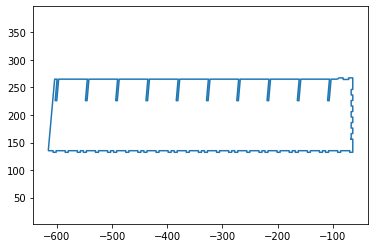

In [21]:
for i in pieces:
    x = []
    y = []
    for j in i:
        x.append(j.a.x)
        y.append(j.a.y)
        x.append(j.b.x)
        y.append(j.b.y)
    plt.plot(x,y)
plt.axis("equal")

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

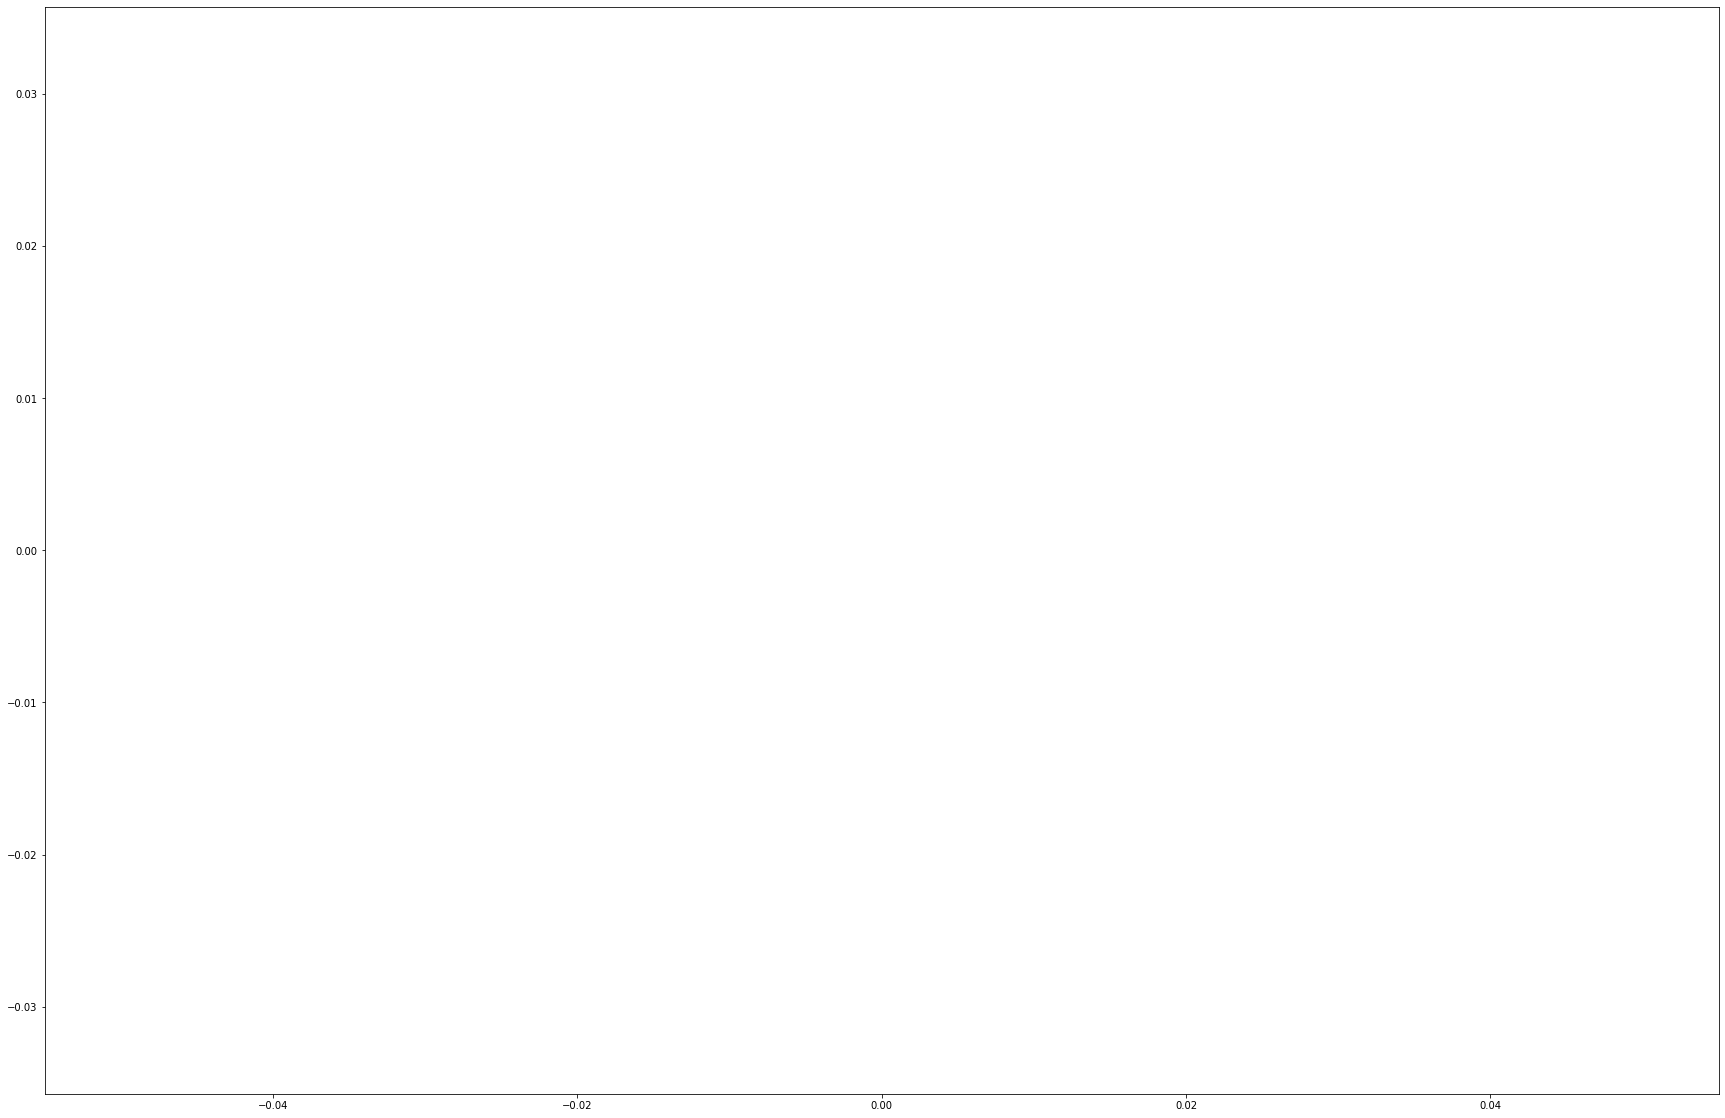

In [22]:
plt.figure(figsize=(30,20))

for k, p1 in enumerate(pieces):
    for p2 in pieces[k+1:]:
        for i in p1:
            for j in p2:                
                if line_overlap(i,j):
                    x = []
                    y = []
                    x.append(j.a.x)
                    y.append(j.a.y)
                    x.append(j.b.x)
                    y.append(j.b.y)
                    plt.plot(x,y,c='b', alpha=0.5, linewidth=5)
                    break
plt.axis("equal")

(-643.1627500000001, -36.012249999999995, 125.481, 273.981)

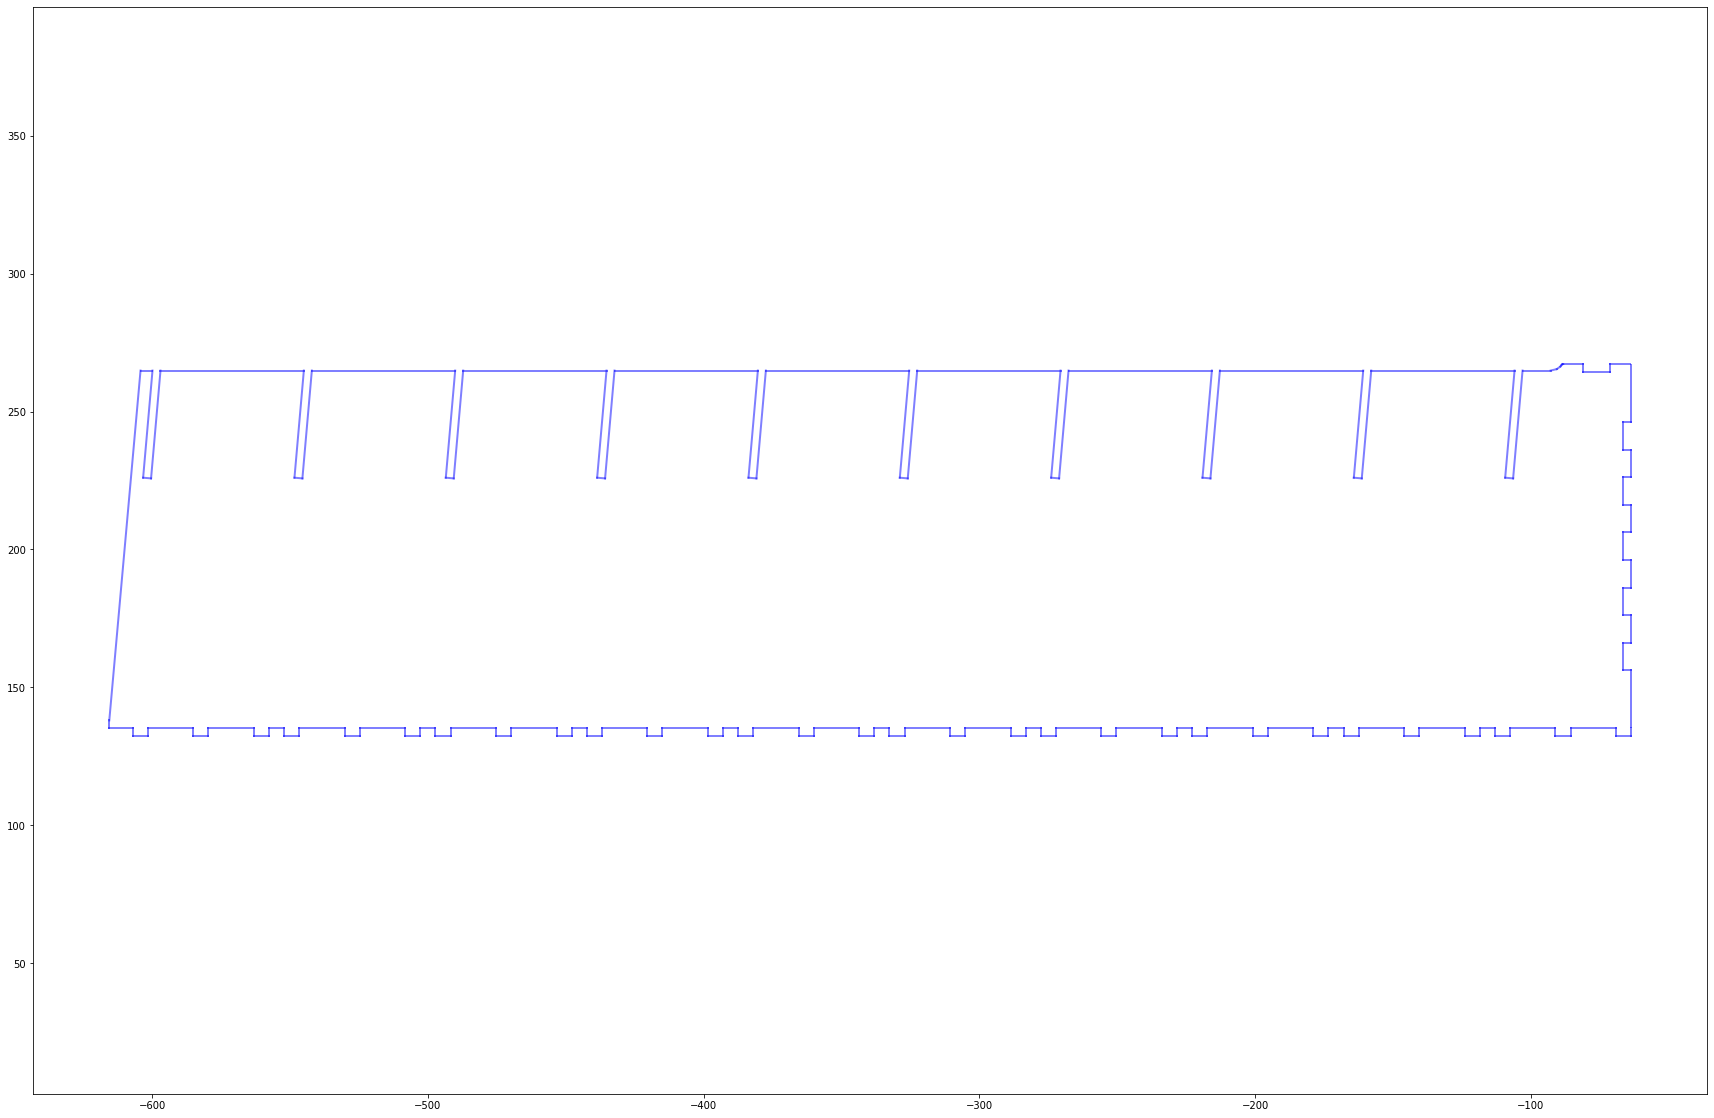

In [23]:
plt.figure(figsize=(30,20))
mapped = []
for i in entities:
    overlap = []
    for k, j in enumerate(mapped):
        if line_overlap(i,j):
            overlap.append(k)
    if overlap:
        overlap_length = 0
        overlap.sort(reverse=True)
        for j in overlap:
            overlap_length += mapped[j].length()
        if i.length() > overlap_length * 1.8:
            for j in overlap:
                del mapped[j]
            mapped.append(i)
    else:
        mapped.append(i)
            
for i in mapped:
    x = []
    y = []
    x.append(i.a.x)
    y.append(i.a.y)
    x.append(i.b.x)
    y.append(i.b.y)
    plt.plot(x,y,c='b', alpha=0.5, linewidth=2)
plt.axis("equal")

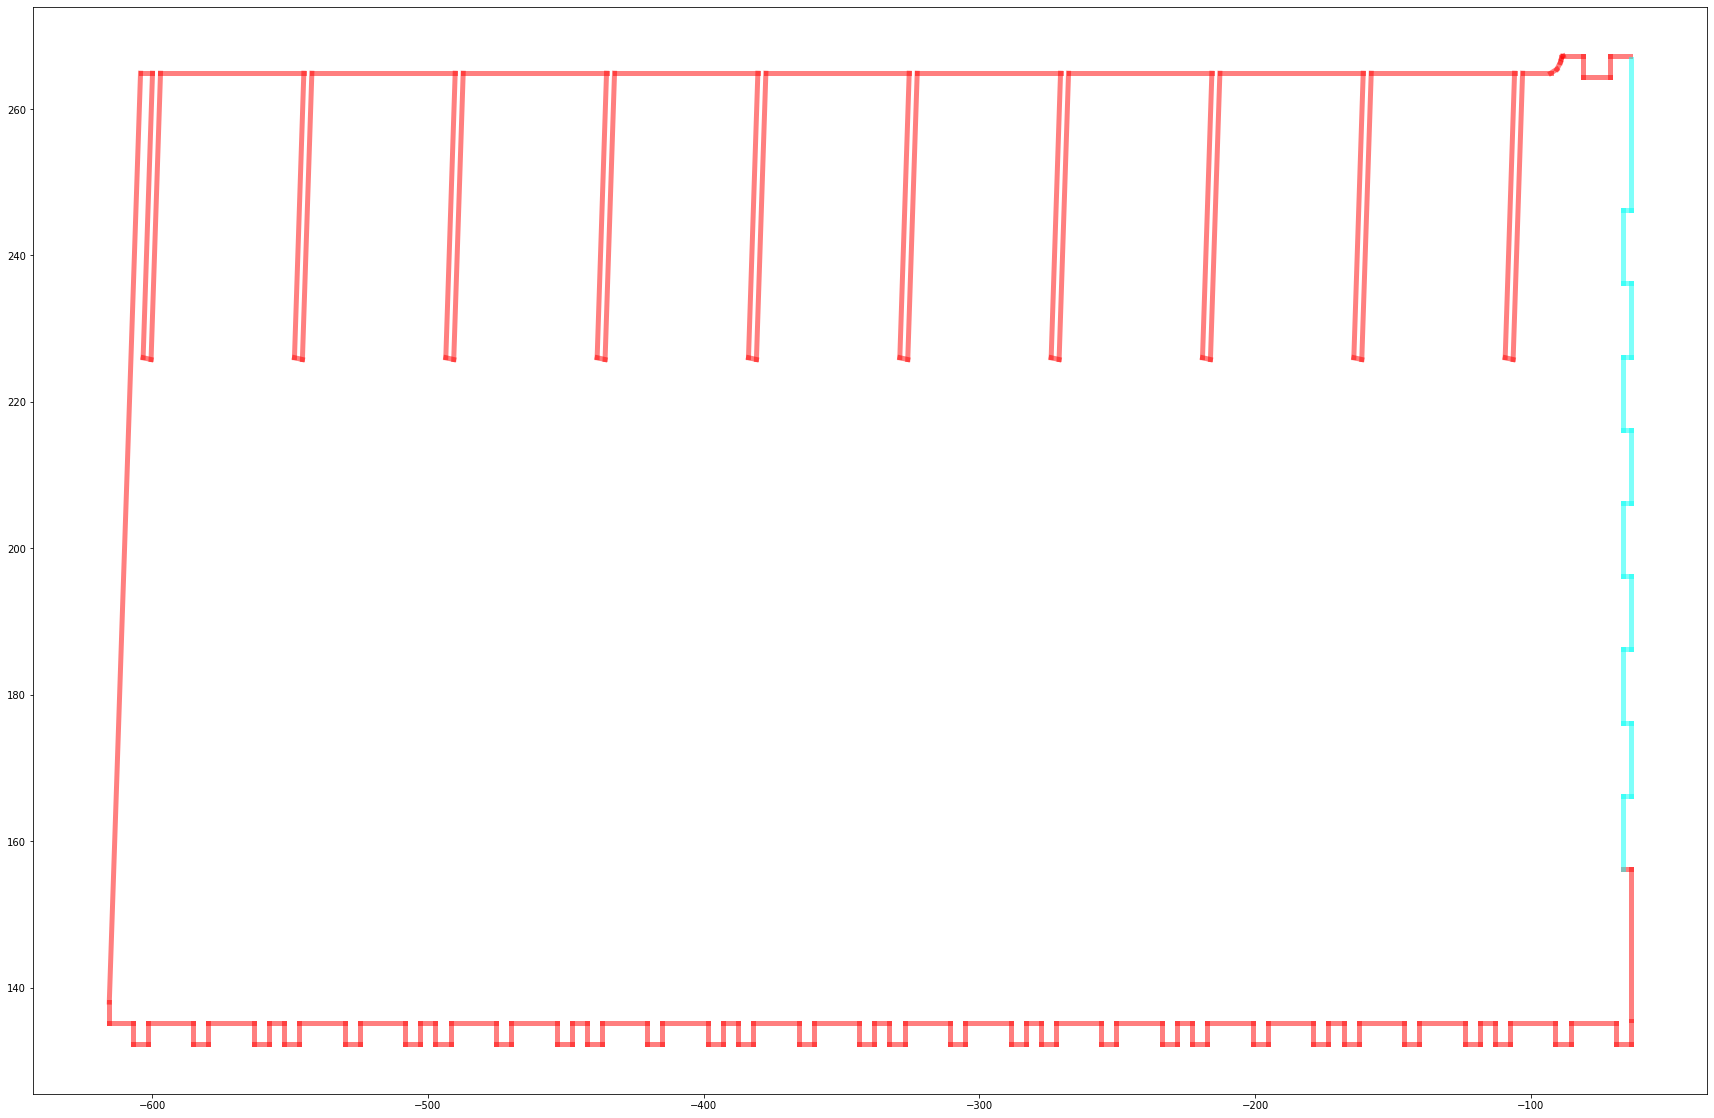

In [24]:
plt.figure(figsize=(30,20))
pieces = [[]]
for i in mapped:
    if pieces[-1] and line(0, pieces[-1][-1].b, i.a).length() > 0.5:
        pieces.append([])
    pieces[-1].append(i)
random.shuffle(pieces)

cmap = plt.cm.hsv
for k,i in enumerate(pieces):
    for j in i:
        x = []
        y = []
        x.append(j.a.x)
        y.append(j.a.y)
        x.append(j.b.x)
        y.append(j.b.y)
        plt.plot(x,y, c=cmap(k/len(pieces)), linewidth=5, alpha=0.5)


2
2
1


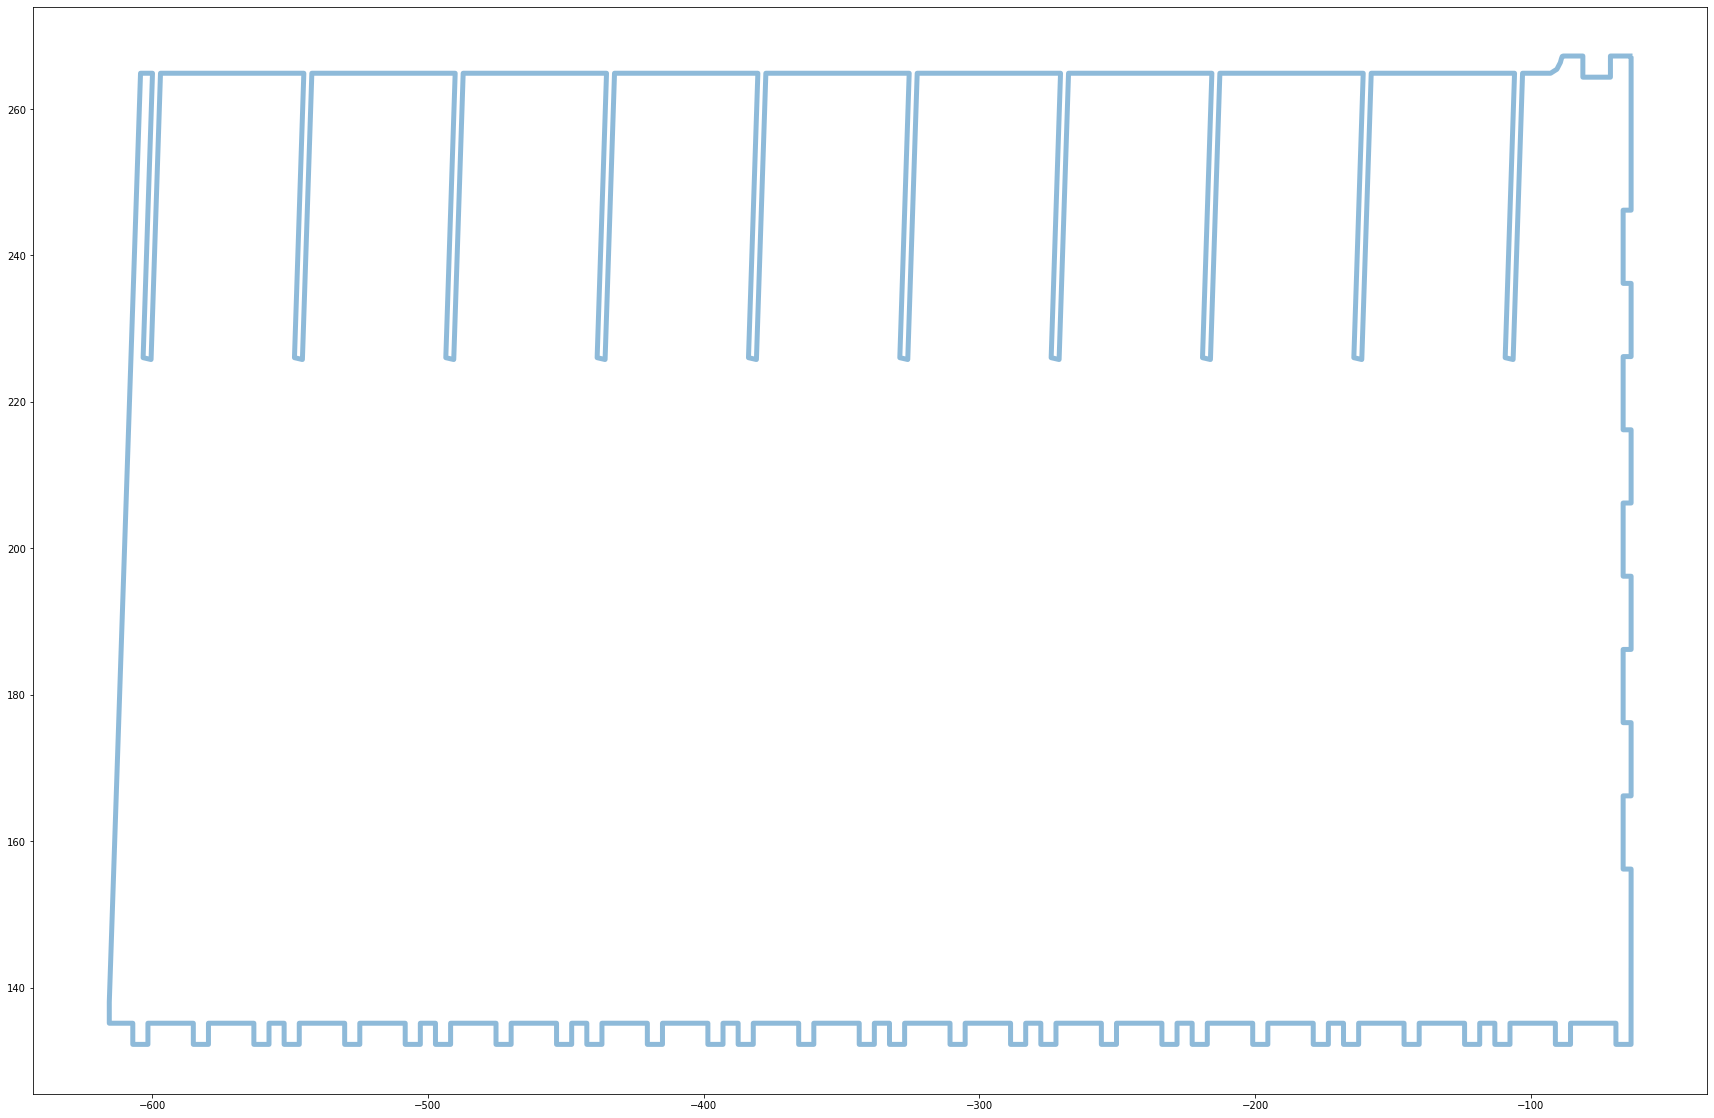

In [25]:
print(len(pieces))
output = []
for i in pieces:
    added = False
    for j in output:
        if line(0, j[-1].b, i[0].a).length() < 0.3:
            j.extend(i)
            added=True
            break
        if line(0, j[0].a, i[0].a).length() < 0.3:
            j.reverse()
            j.extend([line(o.layer, o.b, o.a) for o in i])
            j.reverse()
            added=True
            break
        if line(0, j[-1].b, i[-1].b).length() < 0.3:
            i.reverse()
            j.extend([line(o.layer, o.b, o.a) for o in i])
            i.reverse()
            added=True
            break
        if line(0, j[0].a, i[-1].b).length() < 0.3:
            i.reverse()
            j.reverse()
            j.extend(i)
            j.reverse()
            i.reverse()
            added=True
            break
    if not added:
        output.append(list(i))
print(len(pieces))
print(len(output))
plt.figure(figsize=(30,20))
random.shuffle(output)
for k,i in enumerate(output):
    x = []
    y = []
    for j in i:
        x.append(j.a.x)
        y.append(j.a.y)
        x.append(j.b.x)
        y.append(j.b.y)
    plt.plot(x,y, linewidth=5, alpha=0.5)

In [26]:
min_x = output[0][0].a.x
min_y = output[0][0].a.y
max_x = output[0][0].a.x
max_y = output[0][0].a.y
for i in output:
    for j in i:
        min_x = np.min([j.a.x, min_x, j.b.x])
        min_y = np.min([j.a.y, min_y, j.b.y])
        max_x = np.max([j.a.x, max_x, j.b.x])
        max_y = np.max([j.a.y, max_y, j.b.y])
for i in output:
    for j in i:
        j.a.x -= min_x
        j.a.y -= min_y
        j.b.x -= min_x
        j.b.y -= min_y
print(min_x)
print(min_y)
print(max_x)
print(max_y)

-615.565
132.231
-63.61
267.231


In [44]:
layers = []

layers.append(decode.LayerData(
    color=(0, 0, 1),
    layer=1,
    min_power=decode.scale_power(50),
    max_power=decode.scale_power(50),
    speed= (17) * 1000,
    x_min=0, y_min=0,
    x_max=int((max_x - min_x) * 1000), y_max=int((max_y - min_y) * 1000)))


unpacked_msgs = decode.header(int((max_x - min_x) * 1000), int((max_y - min_y) * 1000), layers)


unpacked_msgs += layers[0].change_header()
for k in range(3):
    for x in pieces:
        unpacked_msgs +=[decode.MoveAbs.from_values(x=int((x[0].a.x) * 1000.0), y=int((x[0].a.y + k*135) * 1000.0))]
        for j in x:
            unpacked_msgs += [
                decode.CutAbs.from_values(x=int((j.b.x) * 1000.0), y=int((j.b.y + k*135) * 1000.0))]

unpacked_msgs += decode.footer(80,80)

repacked = []
    
for i in unpacked_msgs:
    if isinstance(i, decode.CmdMsg):
        repacked += i.pack()
        continue
    repacked += i

out_filename = "backboard.rd"
with open(out_filename, "wb") as f:
    f.write(bytearray(decode.scramble(repacked)))

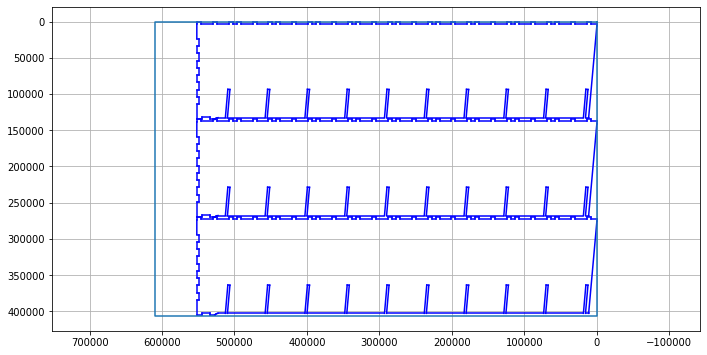

In [45]:
# Output file inspection

with open("backboard.rd", "rb") as f:
    data = decode.unscramble(f.read())
cmds = decode.parse_msgs(decode.split_msg(data))
laser_sim = decode.LaserSimulator()

for i in cmds:
    if isinstance(i, decode.CmdMsg):
        i.update(laser_sim)
laser_sim.show()

plt.plot([0, 0, 25.4 * 24 * 1000, 25.4 * 24 * 1000, 0],[0, 25.4 * 16 * 1000, 25.4 * 16 * 1000, 0, 0])